In [98]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.api import *
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels as sm
from patsy import dmatrix
import scipy as sp
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF

ModuleNotFoundError: No module named 'plotly'

## 가상의 주식 테이블 생성하기
- 시점 $T$ 는 1부터 1000까지 생성
- 개별 종목의 갯수는 400개로 설정
- 난수 발생으로 임의로 정하였기 때문에, 데이터 포맷 그 이상의 의미를 가지지 못한다.

In [2]:
code_df = pd.read_csv('industrial_code.csv')
code_df.rename(columns={'종목코드':'code'},inplace=True)
code_df = code_df[:401]
num_of_stock = 400
T = 1000
df = pd.DataFrame(columns=[i for i in range(1,T+1)])

for i in df.columns:
    df[i] = [0 for i in range(num_of_stock + 1)]
    
df.index = list(code_df['code'])
df.index = [str(i) for i in df.index]

for i in range(len(df)):
    df.iloc[i] = [(np.random.randint(10))*(1+np.random.rand()) for _ in range(1000)]
    
df.index = [str(i) for i in df.index]
df = df.append(pd.Series([1 for _ in range(T)], index=df.columns), ignore_index=True) 
df.rename(index={df.index[-1]:'bias'},inplace=True)
df.rename(index={df.index[-2]:'market'},inplace=True)
individual_stock_df = df[(df.index != 'market') & (df.index != 'bias')]
df.index = list(code_df['code'])[:-1] + ['market','bias']
display(df.tail())
print(df.shape)

,1,2,3,4,5,6,7,8,9,10,...,991,992,993,994,995,996,997,998,999,1000
17810,9.964873,9.141443,5.361756,9.791883,3.089647,1.198437,11.765082,3.881418,1.374357,0.000000,...,7.636414,9.391173,4.780892,3.550154,1.776494,1.623830,11.085557,10.090241,3.947589,9.919635
11200,10.492474,13.861033,12.567612,11.747089,0.000000,11.927321,13.985305,10.631254,11.775968,1.408574,...,3.036602,1.260343,5.656831,11.815835,5.726766,7.898469,4.170299,1.953147,0.000000,3.867590
17390,0.000000,4.765429,3.383035,5.687626,5.902241,4.169320,14.268440,13.921636,1.976126,6.756700,...,1.990709,2.600034,5.114533,6.402019,1.850492,12.980608,0.000000,7.472104,0.000000,5.656483
market,4.293488,0.000000,7.389165,2.715151,2.964884,5.824708,3.890020,6.935306,0.000000,4.719971,...,10.783254,17.586733,0.000000,9.521007,1.905898,2.677348,5.594138,13.457434,1.728601,10.651831
bias,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


(402, 1000)


## 1단계 : 포트폴리오 구성시기 (portfolio formation period)
- 시장모형의 시계열회귀분석으로 개별 종목에 대한 $\beta$ 계수를 추정한다.
- 개별 종목에 대한 $\beta$ 400개 계수 측정이 완료되면, 크기 순으로 나열해서 20개씩 묶어, 포트폴리오를 형성한다.
    - 개별 종목의 갯수를 400개로 한 이유가 이와 같다.

In [3]:
for i,value in enumerate(individual_stock_df.index):
    globals()['model'+str(i)] = OLS(individual_stock_df.loc[value][:400].T,df.loc['market'][:, np.newaxis][:400])
    globals()['result'+str(i)] = globals()['model'+str(i)].fit()
    globals()['params'+str(i)] = globals()['result'+str(i)].params.values[0]
    globals()['resid'+str(i)] = np.std(globals()['result'+str(i)].resid)
#     display(globals()['result'+str(i)].summary())

In [4]:
beta_bundles1 = [globals()['params'+str(i)] for i in range(len(individual_stock_df.index))]
resid_bundles1 = [globals()['resid'+str(i)] for i in range(len(individual_stock_df.index))]
len(beta_bundles1) , len(resid_bundles1)

(400, 400)

In [5]:
rank_df1 = pd.DataFrame()
rank_df1['beta'] = beta_bundles1
rank_df1['resid'] = resid_bundles1
rank_df1['stock'] = df[(df.index != 'market')&(df.index != 'bias')].index
rank_df1.reset_index(inplace=True)
rank_df1.tail()

,index,beta,resid,stock
395,395,0.648960,5.362154,11300
396,396,0.753192,5.519104,12610
397,397,0.700329,5.400137,17810
398,398,0.653678,5.596170,11200
399,399,0.686335,5.456469,17390


In [6]:
sorted_rank_df1 = rank_df1.sort_values(by='beta',ascending=True)
sorted_rank_df1.tail()

,index,beta,resid,stock
265,265,0.747194,5.628205,78930
106,106,0.747969,5.525754,144620
274,274,0.748798,5.303013,74610
396,396,0.753192,5.519104,12610
21,21,0.760146,5.562490,55490


In [7]:
testing_ls = []
ranked_idx_ls = []
popped_ls = list(sorted_rank_df1['index'])
for _ in range(20):
    testing_ls = []
    for _ in range(20):
        testing_ls.append(popped_ls.pop())
    ranked_idx_ls.append(testing_ls)

In [8]:
testing_ls = []
ranked_stock_ls = []
popped_ls = list(sorted_rank_df1['stock'])
for _ in range(20):
    testing_ls = []
    for _ in range(20):
        testing_ls.append(popped_ls.pop())
    ranked_stock_ls.append(testing_ls)

In [9]:
len(ranked_idx_ls[0]) , len(ranked_idx_ls) , len(ranked_stock_ls[0]) , len(ranked_stock_ls)

(20, 20, 20, 20)

In [10]:
sorted_beta_bundles = sorted(beta_bundles1)
len(sorted_beta_bundles)

400

In [11]:
for i in range(20):
    ls = []
    for _ in range(20):
        ls.append(sorted_beta_bundles.pop())
    globals()['portfolio_beta_20_'+str(i)] = ls.copy()

In [12]:
for i in range(20):
    ls = []
    for _ in range(20):
        ls.append(resid_bundles1.pop())
    globals()['portfolio_resid_20_'+str(i)] = ls.copy()

In [13]:
beta_ls1 = []
for i in range(20):
    beta_ls1.append(sum(globals()['portfolio_beta_20_'+str(i)])/len(globals()['portfolio_beta_20_'+str(i)]))
print(beta_ls1)

[0.73908499354273727, 0.72257884478467338, 0.71531661670467039, 0.70817172171301246, 0.70286823558525291, 0.69877286621328683, 0.69474941895943054, 0.69041418494638873, 0.68658965666944549, 0.68358765951490608, 0.6813615433459741, 0.67858346589389262, 0.67530330347527801, 0.67230377498068028, 0.66849913932261473, 0.66440619984900839, 0.66050152822263175, 0.65474671729649536, 0.64758757906410191, 0.63239116087365221]


In [14]:
resid_ls1 = []
for i in range(20):
    resid_ls1.append(sum(globals()['portfolio_resid_20_'+str(i)])/len(globals()['portfolio_resid_20_'+str(i)]))
print(resid_ls1)

[5.495996752247562, 5.435545921166052, 5.53484633046847, 5.472617181718266, 5.507617126388051, 5.464087926108812, 5.505263784989711, 5.4730274378369685, 5.496503643441547, 5.502506448371671, 5.520283852770498, 5.4747454918385365, 5.501345128374099, 5.436300187995277, 5.4342011318634675, 5.451564625556358, 5.41849152843597, 5.493122737865846, 5.538474958011325, 5.461664560825915]


In [15]:
testing_df = pd.DataFrame()
testing_df['beta'] = beta_ls1
testing_df['resid'] = resid_ls1
testing_df['valued_stock_idx'] = ranked_idx_ls
testing_df['valued_stock'] = ranked_stock_ls
testing_df.tail()

,beta,resid,valued_stock_idx,valued_stock
15,0.664406,5.451565,"[259, 246, 131, 234, 238, 61, 23, 341, 314, 29...","[79160, 84010, 11210, 32350, 88790, 39570, 271..."
16,0.660502,5.418492,"[1, 77, 161, 88, 316, 51, 98, 136, 10, 258, 19...","[293940, 204320, 119650, 180640, 42660, 101530..."
17,0.654747,5.493123,"[228, 269, 355, 172, 233, 301, 53, 364, 16, 15...","[92220, 78000, 12320, 47400, 90430, 17370, 194..."
18,0.647588,5.538475,"[134, 163, 386, 289, 348, 375, 395, 157, 378, ...","[134790, 115390, 11160, 69460, 11790, 19180, 1..."
19,0.632391,5.461665,"[322, 283, 245, 87, 281, 383, 327, 363, 57, 21...","[16450, 36570, 79430, 64350, 72130, 17800, 850..."


# 2단계 : 포트폴리오 $\beta$ 의 추정시기 (estimation period)

- 시장 모형의 시계열회귀분석으로 20개 포트폴리오에 대한 $\beta$ 계수를 추정한다.
- 개별 종목에 대한 $\beta_i$ 를 구하고, 포트폴리오를 형성, 시계열 평균으로 $\beta_P$ 를 추정한다.

In [16]:
for i,value in enumerate(individual_stock_df.index):
    globals()['model'+str(i)] = OLS(individual_stock_df.loc[value][400:900].T,df.loc['market'][:, np.newaxis][400:900])
    globals()['result'+str(i)] = globals()['model'+str(i)].fit()
    globals()['params'+str(i)] = globals()['result'+str(i)].params.values[0]
    globals()['resid'+str(i)] = np.std(globals()['result'+str(i)].resid)
#     display(globals()['result'+str(i)].summary())

In [17]:
beta_bundles2 = [globals()['params'+str(i)] for i in range(len(individual_stock_df.index))]
resid_bundles2 = [globals()['resid'+str(i)] for i in range(len(individual_stock_df.index))]
len(beta_bundles2) , len(resid_bundles2)

(400, 400)

In [18]:
rank_df2 = pd.DataFrame()
rank_df2['beta'] = beta_bundles2
rank_df2['resid'] = resid_bundles2
rank_df2['stock'] = df[(df.index != 'market')&(df.index != 'bias')].index
rank_df2.reset_index(inplace=True)
rank_df2.tail()

,index,beta,resid,stock
395,395,0.634239,5.361824,11300
396,396,0.656432,5.564436,12610
397,397,0.695399,5.603914,17810
398,398,0.706839,5.618084,11200
399,399,0.669598,5.639417,17390


In [19]:
beta_ls2 = []
for i in range(len(testing_df['valued_stock_idx'])):
    beta_ls2.append(np.mean(rank_df2.iloc[testing_df['valued_stock_idx'][i]]['beta']))

In [20]:
resid_ls2 = []
for i in range(len(testing_df['valued_stock_idx'])):
    resid_ls2.append(np.mean(rank_df2.iloc[testing_df['valued_stock_idx'][i]]['resid']))

In [21]:
print(beta_ls2)

[0.6667225362867423, 0.664766571291756, 0.6621260322204591, 0.6721958300729913, 0.6567229617574106, 0.6718499723146871, 0.669012986322145, 0.6669035052767207, 0.6668573811616609, 0.6641986438744029, 0.663424431360357, 0.6629338301411212, 0.6643538319992133, 0.66084143348526, 0.6681403174467425, 0.6591236506642685, 0.6639946548313486, 0.6698228055066601, 0.6511502927212429, 0.6649786332256697]


In [22]:
print(resid_ls2)

[5.623207220234443, 5.580417966192834, 5.608261022995711, 5.547538548768044, 5.583841556431405, 5.606607195733367, 5.570794151808185, 5.586988173340033, 5.6185050097902565, 5.624227190356413, 5.513624691978431, 5.589666506916332, 5.5716689509752655, 5.588751845421773, 5.613373264530998, 5.56114392320624, 5.635659233394847, 5.6137295748180795, 5.49398587052034, 5.555838083099461]


In [23]:
final_df = pd.DataFrame()
final_df['beta'] = beta_ls2
final_df['resid'] = resid_ls2
final_df['stock_idx'] = testing_df['valued_stock_idx']
final_df['stock'] = testing_df['valued_stock']

In [35]:
final_df

,beta,resid,stock_idx,stock
0,0.666723,5.623207,"[21, 396, 274, 106, 265, 227, 85, 230, 288, 45...","[55490, 12610, 74610, 144620, 78930, 9770, 688..."
1,0.664767,5.580418,"[311, 83, 101, 192, 372, 195, 257, 360, 153, 1...","[58650, 192820, 159650, 100220, 25540, 32640, ..."
2,0.662126,5.608261,"[190, 328, 38, 171, 62, 12, 242, 223, 30, 307,...","[11070, 36580, 207940, 82640, 2690, 68270, 848..."
3,0.672196,5.547539,"[177, 241, 308, 133, 273, 367, 255, 349, 41, 1...","[53690, 86280, 63160, 134380, 24110, 30720, 42..."
4,0.656723,5.583842,"[109, 254, 14, 189, 353, 373, 221, 59, 201, 26...","[145270, 84670, 285130, 103140, 23960, 3160, 9..."
5,0.671850,5.606607,"[208, 43, 317, 276, 216, 73, 65, 167, 116, 94,...","[94280, 249420, 42670, 7660, 29780, 28260, 214..."
6,0.669013,5.570794,"[339, 237, 137, 93, 96, 354, 247, 325, 284, 67...","[19490, 35510, 126560, 168490, 37560, 23800, 7..."
7,0.666904,5.586988,"[114, 379, 333, 69, 68, 380, 331, 90, 76, 319,...","[140890, 6740, 6650, 138250, 210980, 910, 2409..."
8,0.666857,5.618505,"[275, 187, 277, 235, 321, 9, 173, 132, 95, 107...","[25750, 104700, 35250, 90080, 10040, 88260, 93..."
9,0.664199,5.624227,"[145, 256, 287, 25, 303, 198, 294, 202, 184, 2...","[2150, 4890, 11500, 271560, 24720, 101060, 335..."


In [74]:
def real_df(T=0):
    gamma_1 , gamma_2 , gamma_3 , gamma_4 = [],[],[],[]
    real_df = pd.DataFrame()
    ls = []
    for i in final_df['beta']:
        for _ in range(20):
            ls.append(i)
    real_df['beta'] = ls
    ls = []        
    for i in final_df['resid']:
        for _ in range(20):
            ls.append(i)
    real_df['resid'] = ls
    real_df['y'] = [individual_stock_df.iat[int(k),T] for k in [j for i in final_df['stock_idx'].values for j in i]]
    model = OLS.from_formula('y ~ beta + I(beta ** 2) + resid',real_df)
    result = model.fit()
    gamma_1.append(result.params[0])
    gamma_2.append(result.params[1])
    gamma_3.append(result.params[2])
    gamma_4.append(result.params[3])
    return gamma_1 , gamma_2 , gamma_3 , gamma_4

In [77]:
real_ls = [real_df(T) for T in range(len(individual_stock_df.columns))]

In [83]:
gamma_1 = [real_ls[i][0] for i in range(1000)]
gamma_2 = [real_ls[i][0] for i in range(1000)]
gamma_3 = [real_ls[i][0] for i in range(1000)]
gamma_4 = [real_ls[i][0] for i in range(1000)]

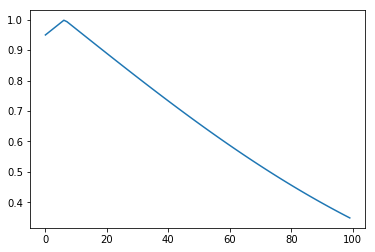

In [100]:
plt.plot([sp.stats.ttest_1samp(gamma_1, popmean=i)[1][0] for i in range(100)])

In [92]:
sp.stats.ttest_1samp(gamma_3, popmean=0)[1][0]

0.949995169853878

In [93]:
sp.stats.ttest_1samp(gamma_4, popmean=0)[1][0]

0.949995169853878